preperations

In [ ]:
import numpy as np
import copy
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

### Q1

a

In [ ]:
def initialize_parameters(layer_dims):
    '''
    input: an array of the dimensions of each layer in the network (layer 0 is the size of the flattened input, layer L is the output softmax)

    output: a dictionary containing the initialized W and b parameters of each layer (W1…WL, b1…bL).
    '''
    params = {'W':[], 'b':[]}
    scale_param = 0.5  # in order to not get too large random values

    for l in range(1, len(layer_dims)):
      W = np.random.randn(layer_dims[l], layer_dims[l-1]) * scale_param
      B = np.zeros((layer_dims[l], 1))

      params['W'].append(W)
      params['b'].append(B)
    return params

b

In [ ]:
def linear_forward(A, W, b):
  """
  Description: Implement the linear part of a layer's forward propagation.

  input:
  A – the activations of the previous layer
  W – the weight matrix of the current layer (of shape [size of current layer, size of previous layer])
  B – the bias vector of the current layer (of shape [size of current layer, 1])

  Output:
  Z – the linear component of the activation function (i.e., the value before applying the non-linear function)
  linear_cache – a dictionary containing A, W, b (stored for making the backpropagation easier to compute)
  """
  Z = np.dot(W, A) + b  # applying linear function, matrix multiplication of A and W, then add the bias b
  linear_cache = {'A': A, 'W': W, 'b': b}

  return Z, linear_cache

c

In [ ]:
def softmax(Z):
  """
  purpose: implement softmax function
  Input:
  Z – the linear component of the activation function

  Output:
  A – the activations of the layer
  activation_cache – returns Z, which will be useful for the backpropagation

  Softmax〖(z)〗_i=(exp⁡(z_i))/(∑_j▒〖exp⁡(z_j)〗)
  """
  exp = np.exp(Z- np.max(Z, axis=0, keepdims=True))
  A = exp / np.sum(exp,axis=0, keepdims=True)
  activation_cache = {'Z' : Z}

  return A, activation_cache

d

In [ ]:
def relu(Z):
  """
  purpose: implement relu function
  Input:
  Z – the linear component of the activation function

  Output:
  A – the activations of the layer
  activation_cache – returns Z, which will be useful for the backpropagation

  relu(x) : max(0,x)
  """
  A = np.maximum(0, Z)
  activation_cache = {'Z' : Z}

  return A, activation_cache

e

In [ ]:
def linear_activation_forward(A_prev, W, B, activation):
  """
  Description: Implement the forward propagation for the LINEAR->ACTIVATION layer

  Input:
  A_prev – activations of the previous layer
  W – the weights matrix of the current layer
  B – the bias vector of the current layer
  Activation – the activation function to be used (a string, either “softmax” or “relu”)

  Output:
  A – the activations of the current layer
  cache – a joint dictionary containing both linear_cache and activation_cache
  """
  Z, linear_cache = linear_forward(A_prev,W, B)

  if activation == "softmax":
    A, activation_cache = softmax(Z)

  else: # relu
    A, activation_cache = relu(Z)

  cache = {"linear": linear_cache, "activation": activation_cache}
  return A, cache

f

In [ ]:
def L_model_forward(X, parameters, use_batchnorm):
  """
  Description: Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation

  Input:
  X – the data, numpy array of shape (input size, number of examples)
  parameters – the initialized W and b parameters of each layer
  use_batchnorm - a boolean flag used to determine whether to apply batchnorm after the activation
  (note that this option needs to be set to “false” in Section 3 and “true” in Section 4).

  Output:
  AL – the last post-activation value
  caches – a list of all the cache objects generated by the linear_forward function
  """
  caches = []
  A = X
  num_of_layers = len(parameters['W'])

  # LINEAR->RELU
  for i in range(0,num_of_layers- 1):

    if use_batchnorm:
      A = apply_batchnorm(A)

    A, cache = linear_activation_forward(A, parameters['W'][i], parameters['b'][i], 'relu')
    caches.append(cache)



  # LINEAR->SOFTMAX
  A, cache = linear_activation_forward(A, parameters['W'][-1], parameters['b'][-1], 'softmax')
  caches.append(cache)

  return A, caches



g

In [ ]:
def compute_cost(AL, Y, parameters, lamda = 0):
  """
  Description: Implement the cost function defined by equation. The requested cost function is categorical cross-entropy loss.
  The formula is as follows : cost=-1/m*∑_1^m▒∑_1^C▒〖y_i  log⁡〖(y ̂)〗 〗,
  where y_i is one for the true class (“ground-truth”) and y ̂ is the softmax-adjusted prediction.

  Input:
  AL – probability vector corresponding to your label predictions, shape (num_of_classes, number of examples)
  Y – the labels vector (i.e. the ground truth)

  Output:
  cost – the cross-entropy cost
  """
  epsilon = 1e-9
  lamda = 0.04
  m = AL.shape[1]  # number of examples

  # Correcting Y shape to be the same as AL
  Y_zeros = np.zeros_like(AL)
  for i in range(len(Y)):
      val = Y[i].item()
      Y_zeros[val, i] = 1

  # Compute the cross-entropy cost
  cost = (-1/m) * np.sum(Y_zeros * np.log(AL + epsilon))

  l2 = 0
  if lamda > 0:
   for value in parameters['W']:
    l2 += np.sum(np.square(value))

  final_cost = cost + (lamda / (2 * m)) * l2
  return final_cost

h

In [ ]:
def apply_batchnorm(A):
  """
  Description: performs batchnorm on the received activation values of a given layer.

  Input:
  A - the activation values of a given layer

  output:
  NA - the normalized activation values, based on the formula learned in class
  """
  epsilon = 1e-15  # Avoiding division by zero
  A_mean = np.mean(A, axis=0, keepdims=True)
  A_variance = np.var(A, axis=0, ddof=0, keepdims=True)
  NA = (A - A_mean) / np.sqrt(A_variance + epsilon)

  return NA


###Q2

a

In [ ]:
def Linear_backward(dZ, cache, lamda = 0):
  """
  description: Implements the linear part of the backward propagation process for a single layer

  Input:
  dZ – the gradient of the cost with respect to the linear output of the current layer (layer l)
  cache – tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

  Output:
  dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW -- Gradient of the cost with respect to W (current layer l), same shape as W
  db -- Gradient of the cost with respect to b (current layer l), same shape as b
  """

  m = cache['A'].shape[1]
  dA_prev = np.dot(cache['W'].T, dZ)
  dW = np.dot(dZ, cache['A'].T) / m + ((lamda / m) * cache['W'])
  db = np.sum(dZ, axis=1, keepdims=True) / m

  return dA_prev, dW, db


b

In [ ]:
def linear_activation_backward(dA, cache, activation, lamda = 0):
  """
  Description: Implements the backward propagation for the LINEAR->ACTIVATION layer.
  The function first computes dZ and then applies the linear_backward function.

  Input:
  dA – post activation gradient of the current layer
  cache – contains both the linear cache and the activations cache
  activation = softmax/relu

  Output:
  dA_prev – Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
  dW – Gradient of the cost with respect to W (current layer l), same shape as W
  db – Gradient of the cost with respect to b (current layer l), same shape as b
  """
  if activation == 'relu':
    dZ = relu_backward(dA, cache['activation'])

  else: # softmax
    dZ = softmax_backward(dA, cache['activation'])

  tmp = cache['linear']
  dA_prev, dW, db = Linear_backward(dZ, cache['linear'],lamda)

  return dA_prev, dW, db

c

In [ ]:
def relu_backward(dA, activation_cache):
  """
  Description: Implements backward propagation for a ReLU unit

  Input:
  dA – the post-activation gradient
  activation_cache – contains Z (stored during the forward propagation)

  Output:
  dZ – gradient of the cost with respect to Z
  """
  Z = activation_cache['Z']
  dZ = np.where(Z > 0, 1, 0)

  return dZ*dA

d

In [ ]:
def softmax_backward(dA, activation_cache):
  """
  Description:Implements backward propagation for a softmax unit

  Input:
  dA – the post-activation gradient // Actually we pass the Y values
  activation_cache – contains Z (stored during the forward propagation)

  Output:
  dZ – gradient of the cost with respect to Z
  """
  return dA

e

In [ ]:
def L_model_backward(AL, Y, caches, lamda = 0):
  """
  Description: Implement the backward propagation process for the entire network.

  Input:
  AL - the probabilities vector, the output of the forward propagation (L_model_forward)
  Y - the true labels vector (the "ground truth" - true classifications)
  Caches - list of caches containing for each layer: a) the linear cache; b) the activation cache

  Output:
  Grads - a dictionary with the gradients
              grads["dA" + str(l)] = ...
              grads["dW" + str(l)] = ...
              grads["db" + str(l)] = ...

  """
  Grads = {}
  # reshape Y to ba like AL
  Y_zeros = np.zeros_like(AL)
  for i in range(len(Y)):
      val = Y[i].item()
      Y_zeros[val, i] = 1
  matrix_y = np.eye(AL.shape[0])[Y].T # True labels from vector to matrix
  dZ = AL - matrix_y # gradient of the cost with respect to Z
  for i in range(len(caches) - 1, -1, -1):
    if i == len(caches) - 1:
      dA_prev, dW, db = linear_activation_backward(dZ, caches[i], "softmax", lamda)
    else:
      dA_prev, dW, db = linear_activation_backward(dA_prev, caches[i], "relu", lamda)

    Grads["dA" + str(i)] = dA_prev
    Grads["dW" + str(i)] = dW
    Grads["db" + str(i)] = db

  return Grads

f

In [ ]:
def Update_parameters(parameters, grads, learning_rate):
  """
  Description: Updates parameters using gradient descent

  Input:
  parameters – a python dictionary containing the DNN architecture’s parameters
  grads – a python dictionary containing the gradients (generated by L_model_backward)
  learning_rate – the learning rate used to update the parameters (the “alpha”)

  Output:
  parameters – the updated values of the parameters object provided as input
  """
  W = parameters['W']
  b = parameters['b']

  for i in range(len(W)):
    W[i] = W[i] - learning_rate * grads['dW'+ str(i)]
    b[i] = b[i] - learning_rate * grads['db' + str(i)].reshape(-1,1)

  return {'W' : W, 'b': b}



###Q3

a

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, l2=False, lamda = 0, use_batchnorm = False):
  """
  Input:
  X – the input data, a numpy array of shape (height*width , number_of_examples)
  Comment: since the input is in grayscale we only have height and width, otherwise it would have been height*width*3
  Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
  Layer_dims – a list containing the dimensions of each layer, including the input
  batch_size – the number of examples in a single training batch.

  Output:
  parameters – the parameters learnt by the system during the training (the same parameters that were updated in the update_parameters function).
  costs – the values of the cost function (calculated by the compute_cost function).
  One value is to be saved after each 100 training iterations (e.g. 3000 iterations -> 30 values).
  """
  # shuf_idx = np.arange(X.shape[1])
  # np.random.shuffle(shuf_idx)
  # val_size = int(len(shuf_idx) * 0.2)
  # val_idx, train_idx = shuf_idx[:val_size], shuf_idx[val_size:]
  # x_train, x_val, y_train, y_val = X[:,train_idx], X[:,val_idx], Y[train_idx], Y[val_idx]
  m = X.shape[1]
  indices = np.random.permutation(m)
  train_size = int(m * 0.8)

  train_indices = indices[:train_size]
  val_indices = indices[train_size:]

  x_train, x_val = X[:, train_indices], X[:, val_indices]
  y_train, y_val = Y[train_indices], Y[val_indices]

  parameters = initialize_parameters(layers_dims)  # {'W': [], 'b': []}
  costs = {'train' : [], 'Validation': []}
  improvement = True
  iter = 0
  current_val_accuracy = 0
  priviuos_val_accuracy = 0
  batch_idx = 0
  train_batches = create_batches(x_train, y_train, batch_size)

  while improvement and iter<num_iterations:

    for start in range(0, x_train.shape[1], batch_size):
      end = start + batch_size
      batch_X = x_train[:, start:end]
      batch_Y = y_train[start:end]
      AL, caches = L_model_forward(batch_X, parameters, use_batchnorm)
      Grads = L_model_backward(AL,batch_Y,caches, lamda)
      parameters = Update_parameters(parameters, Grads, learning_rate)
      batch_idx += 1
      if batch_idx+= % 100 == 0:
        AL_v, _ = L_model_forward(x_val, parameters, use_batchnorm)
        cost_t = compute_cost(AL, batch_Y,parameters, lamda)
        cost_v = compute_cost(AL_v, y_val,parameters, lamda)
        costs['train'].append(cost_t)
        costs['Validation'].append(cost_v)
        current_val_accuracy = Predict(x_val, y_val, parameters)
        improvement = (priviuos_val_accuracy + 0.00001) < current_val_accuracy
        priviuos_val_accuracy = current_val_accuracy
        print(f"iteration: {iter}, batch: {batch_idx+1}, training cost: {cost_t}, validation accuracy: {current_val_accuracy}")


    iter += 1



  training_accuracy = Predict(x_train,y_train, parameters)
  validation_accuracy = Predict(x_val, y_val, parameters)

  print("Final Results: ")
  print(f"Training Accuracy: {training_accuracy}")
  print(f"Validation Accuracy: {validation_accuracy}")


  return parameters, costs


In [ ]:
def split_dataset(X, Y, train_ratio=0.8, seed=10):
    """
    Splits the dataset into training and validation sets.

    Parameters:
    - X: Input features, numpy array of shape (n_features, m_examples).
    - Y: Labels, numpy array of shape (n_labels, m_examples).
    - train_ratio: Percentage of the dataset to be used as training set.
    - seed: Random seed for reproducibility.

    Returns:
    - X_train, X_val: Training and validation sets of features.
    - Y_train, Y_val: Training and validation sets of labels.
    """
    m = X.shape[1]
    indices = np.random.permutation(m)
    train_size = int(m * train_ratio)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    X_train, X_val = X[:, train_indices], X[:, val_indices]
    Y_train, Y_val = Y[:, train_indices], Y[:, val_indices]

    return X_train, X_val, Y_train, Y_val

In [ ]:
def create_batches(x, y, batch_size):
  num_of_examples = x.shape[1]
  suffeld_indices = list(range(num_of_examples))
  np.random.shuffle(suffeld_indices)
  batches = []

  for i in range(0, num_of_examples, batch_size):
      generated_batch_indices = suffeld_indices[i:i + batch_size]
      batches.append((x[:, generated_batch_indices], y[generated_batch_indices]))
  return batches

b

In [ ]:
def Predict(X, Y, parameters):
  """
  Description: The function receives an input data and the true labels and calculates
  the accuracy of the trained neural network on the data.

  Input:
  X – the input data, a numpy array of shape (height*width, number_of_examples)
  Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
  Parameters – a python dictionary containing the DNN architecture’s parameters

  Output:
  accuracy – the accuracy measure of the neural net on the provided data
  (i.e. the percentage of the samples for which the correct label receives the hughest confidence score).
  Use the softmax function to normalize the output values.

  """

  AL,ca = L_model_forward(X, parameters, False)
  Preds = np.argmax(AL, axis=0)
  correct_preds = int(np.sum(Y == Preds))
  accuracy = correct_preds / Y.shape[0]

  return accuracy

####Q4

In [ ]:
def load_Mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], 784).T / 255
  x_test = x_test.reshape(x_test.shape[0], 784).T / 255
  return (x_train, y_train), (x_test, y_test)

In [ ]:
def main(batch_size):
  (x_train, y_train), (x_test, y_test) = load_Mnist() # x : [784, 6000]
  parameters, costs_list = L_layer_model(x_train, y_train, [784,20,7,5,10], 0.009, 100, batch_size, l2=False, lamda=0.0, use_batchnorm=False)
  test_accuracy = Predict(x_test, y_test, parameters)
  print(f"test accuracy: {test_accuracy}")
  return costs_list

In [ ]:
import matplotlib.pyplot as plt

def plot_costs(costs):
    # Assuming costs1 and costs2 are lists of costs for each training step
    plt.figure(figsize=(10, 6))
    # Plotting the first set of costs
    plt.plot(costs['train'], label='training cost',  marker='o', linestyle='-', color='b', markersize=1 )

    # Plotting the second set of costs
    plt.plot(costs['Validation'], label='validation cost', marker='o', linestyle='-', color='r', markersize=1 )

    # Adding labels and title
    plt.xlabel('Training Step')
    plt.ylabel('Cost')
    plt.title('Cost as a Function of Training Step')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

no batch norm and no l2

In [ ]:
costs_32_no_norm = main(batch_size = 32)

iteration: 0, batch: 101, training cost: 4.774063049643108, validation accuracy: 0.12791666666666668
iteration: 0, batch: 201, training cost: 4.812139319430007, validation accuracy: 0.11441666666666667
iteration: 0, batch: 301, training cost: 4.744482882027469, validation accuracy: 0.13333333333333333
iteration: 0, batch: 401, training cost: 4.736781353860083, validation accuracy: 0.15025
iteration: 0, batch: 501, training cost: 4.606737308385897, validation accuracy: 0.168
iteration: 0, batch: 601, training cost: 4.496505351371688, validation accuracy: 0.18591666666666667
iteration: 0, batch: 701, training cost: 4.566473891063259, validation accuracy: 0.21175
iteration: 0, batch: 801, training cost: 4.4728697920244755, validation accuracy: 0.216
iteration: 0, batch: 901, training cost: 4.524056904620711, validation accuracy: 0.2635
iteration: 0, batch: 1001, training cost: 4.412199438770399, validation accuracy: 0.2738333333333333
iteration: 0, batch: 1101, training cost: 4.6288402369

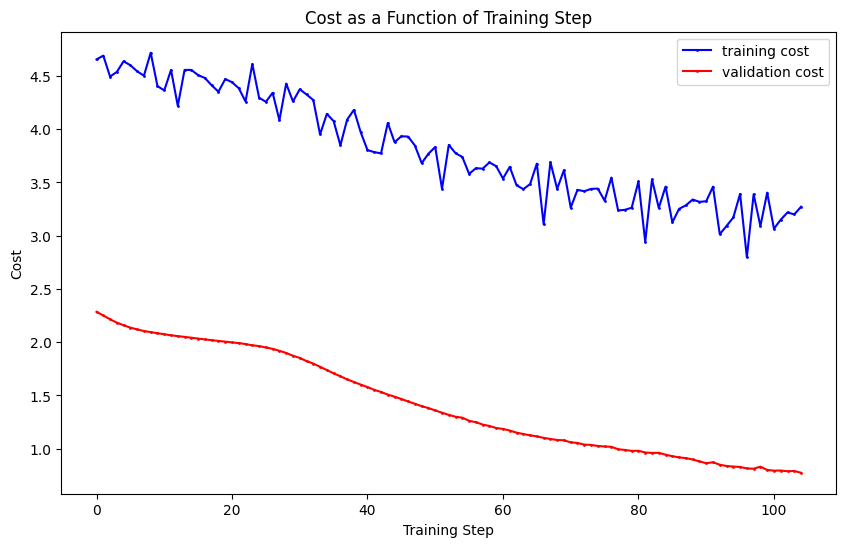

In [ ]:
plot_costs(costs_32_no_norm)

yes batch norm no L2

In [ ]:
costs_32_batch_norm = main(batch_size = 32)

iteration: 0, batch: 100, training cost: 4.696798054416451, validation accuracy: 0.17641666666666667
iteration: 0, batch: 200, training cost: 4.303443490505102, validation accuracy: 0.21483333333333332
iteration: 0, batch: 300, training cost: 4.382065057846749, validation accuracy: 0.26216666666666666
iteration: 0, batch: 400, training cost: 4.222024188013132, validation accuracy: 0.28225
iteration: 0, batch: 500, training cost: 4.276235911678668, validation accuracy: 0.29675
iteration: 0, batch: 600, training cost: 4.573436606552114, validation accuracy: 0.32325
iteration: 0, batch: 700, training cost: 4.335002402626036, validation accuracy: 0.32133333333333336
iteration: 0, batch: 800, training cost: 4.520040251887632, validation accuracy: 0.34841666666666665
iteration: 0, batch: 900, training cost: 4.330865653129688, validation accuracy: 0.3506666666666667
iteration: 0, batch: 1000, training cost: 4.267601586640502, validation accuracy: 0.3645
iteration: 0, batch: 1100, training cos

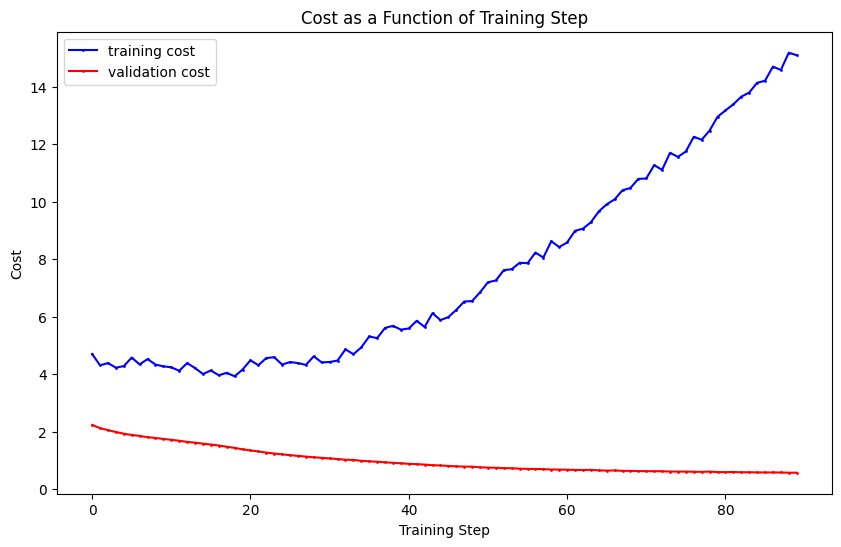

In [ ]:
plot_costs(costs_32_batch_norm)

No batch, Yes L2

In [ ]:
costs_32_no_batch_yes_l2 = main(batch_size = 32)

iteration: 0, batch: 100, training cost: 4.759987083035929, validation accuracy: 0.115
iteration: 0, batch: 200, training cost: 4.682514074747821, validation accuracy: 0.12208333333333334
iteration: 0, batch: 300, training cost: 4.639517333803714, validation accuracy: 0.12841666666666668
iteration: 0, batch: 400, training cost: 4.672105545570419, validation accuracy: 0.13616666666666666
iteration: 0, batch: 500, training cost: 4.649029900648872, validation accuracy: 0.12683333333333333
iteration: 0, batch: 600, training cost: 4.668336639305571, validation accuracy: 0.14433333333333334
iteration: 0, batch: 700, training cost: 4.627249068926007, validation accuracy: 0.14416666666666667
iteration: 0, batch: 800, training cost: 4.622423648412656, validation accuracy: 0.15091666666666667
iteration: 0, batch: 900, training cost: 4.7937363395087775, validation accuracy: 0.14933333333333335
iteration: 0, batch: 1000, training cost: 4.587621232726724, validation accuracy: 0.152
iteration: 0, ba

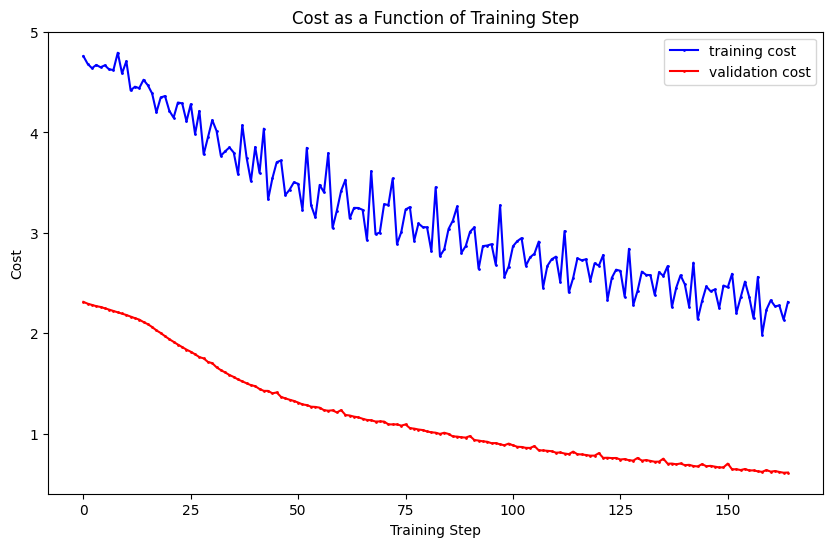

In [ ]:
plot_costs(costs_32_no_batch_yes_l2)

yes batch norm & L2

In [ ]:
costs_32_yes_batch_yes_l2 = main(batch_size = 32)

iteration: 0, batch: 100, training cost: 4.795406396365344, validation accuracy: 0.21733333333333332
iteration: 0, batch: 200, training cost: 4.524625048873087, validation accuracy: 0.2525833333333333
iteration: 0, batch: 300, training cost: 4.4798486154920125, validation accuracy: 0.27525
iteration: 0, batch: 400, training cost: 4.586359103553151, validation accuracy: 0.28275
iteration: 0, batch: 500, training cost: 4.652401298014423, validation accuracy: 0.3135
iteration: 0, batch: 600, training cost: 4.402419387386487, validation accuracy: 0.32266666666666666
iteration: 0, batch: 700, training cost: 4.18609870266717, validation accuracy: 0.3365
iteration: 0, batch: 800, training cost: 4.319083187532709, validation accuracy: 0.35733333333333334
iteration: 0, batch: 900, training cost: 4.151659321746315, validation accuracy: 0.37925
iteration: 0, batch: 1000, training cost: 4.033278402855896, validation accuracy: 0.4033333333333333
iteration: 0, batch: 1100, training cost: 4.344889561

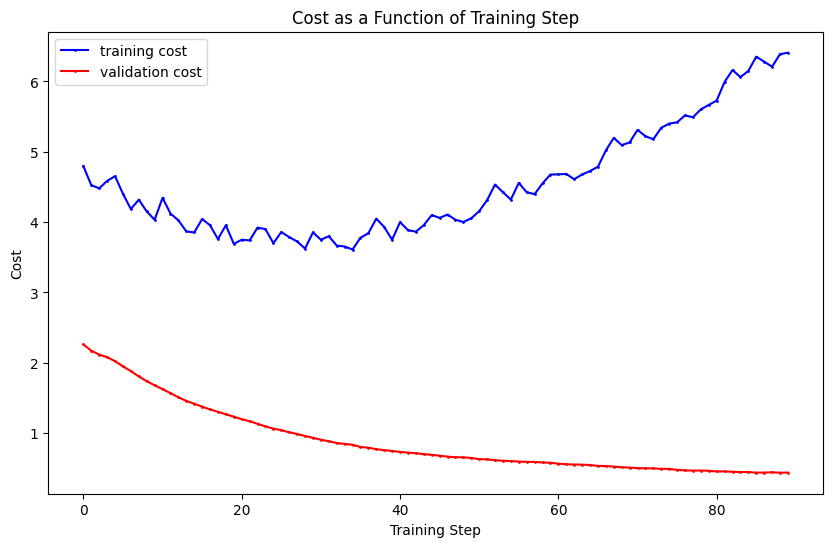

In [ ]:
plot_costs(costs_32_yes_batch_yes_l2)